In [ ]:
# DEPENDENCIES ########################################################################################################################################

%pip install keras
%pip install pandas
%pip install scikit_image
%pip install h5py

In [1]:
# IMPORTS #############################################################################################################################################

import numpy as np
import pandas as pd
from tensorflow.python.lib.io import file_io
from skimage.transform import resize
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import TensorBoard, ReduceLROnPlateau, EarlyStopping, Callback, LearningRateScheduler

In [2]:
# PARAMETERS ##########################################################################################################################################

# Size of the images
img_height, img_width = 139, 139

# Parameters
num_classes         = 7     # ['Anger', 'Disgust', 'Fear', 'Happiness', 'Sadness', 'Surprise', 'Neutral']
epochs_top_layers   = 5
epochs_all_layers   = 100
batch_size          = 128

In [3]:
# DATASETS ############################################################################################################################################

# Folder where logs and models are stored
folder = 'C:/Users/skywalker/Desktop/Meriem_TAIEB_yasmine_MAHDOUI/facial_emotion_recognition/logs/Inceptionv3'

# Data paths
train_dataset	= 'C:/Users/skywalker/Desktop/Meriem_TAIEB_yasmine_MAHDOUI/facial_emotion_recognition/fer2013/train'
eval_dataset 	= 'C:/Users/skywalker/Desktop/Meriem_TAIEB_yasmine_MAHDOUI/facial_emotion_recognition/fer2013/validation'

In [4]:
# MODEL ###############################################################################################################################################

# Create the base pre-trained model
    # include_top:  Whether to include the fully-connected layer at the top of the network
    # weights:      Pre-training on ImageNet
    # input_shape:  Optional shape tuple, only to be specified if include_top is False (otherwise the input shape has to be (299, 299, 3) 
    #               (with 'channels_last' data format) or (3, 299, 299) (with 'channels_first' data format). It should have exactly 3 inputs channels, 
    #               and width and height should be no smaller than 139. E.g. (150, 150, 3) would be one valid value
# Returns a keras Model instance
base_model = InceptionV3(
    include_top = False,
    weights     = 'imagenet',
    input_shape = (img_height, img_width, 3))

# Places x as the output of the pre-trained model
x = base_model.output

# Add a global spatial average pooling layer
    # data_format:  The ordering of the dimensions in the inputs. Default: channels_last (batch, height, width, channels)
    # input shape:  4D tensor with shape: (batch_size, rows, cols, channels)
    # output shape: 2D tensor with shape: (batch_size, channels) => (None, 2048)
x = GlobalAveragePooling2D()(x)

# Add a fully-connected layer and a logistic layer
# Dense implements the operation: output = activation(dot(input, kernel) + bias(only applicable if use_bias is True))
    # units:        Positive integer, dimensionality of the output space
    # activation:   Activation function to use
    # input shape:  nD tensor with shape: (batch_size, ..., input_dim)
    # output shape: nD tensor with shape: (batch_size, ..., units)
x = Dense(1024, activation = 'relu')(x)
predictions = Dense(num_classes, activation = 'softmax')(x)

# The model we will train
model = Model(inputs = base_model.input, outputs = predictions)



In [6]:
print('numuber of layers',len(model.layers))

numuber of layers 314


In [5]:
# DATA PREPARATION ####################################################################################################################################

# def preprocess_input(x):
#     x -= 128.8006 # np.mean(train_dataset)
#     return x

# # Function that reads the data from the csv file, increases the size of the images and returns the images and their labels
#     # dataset: Data path
# def get_data(dataset):
#     file_stream = file_io.FileIO(dataset, mode='r')
#     data = pd.read_csv(file_stream)
#     pixels = data['pixels'].tolist()
#     images = np.empty((len(data), img_height, img_width, 3))
#     i = 0

#     for pixel_sequence in pixels:
#         single_image = [float(pixel) for pixel in pixel_sequence.split(' ')]  # Extraction of each single
#         single_image = np.asarray(single_image).reshape(48, 48) # Dimension: 48x48
#         single_image = resize(single_image, (img_height, img_width), order = 3, mode = 'constant') # Dimension: 139x139x3 (Bicubic)
#         ret = np.empty((img_height, img_width, 3))  
#         ret[:, :, 0] = single_image
#         ret[:, :, 1] = single_image
#         ret[:, :, 2] = single_image
#         images[i, :, :, :] = ret
#         i += 1
    
#     images = preprocess_input(images)
#     labels = to_categorical(data['emotion'])

#     return images, labels    

# # Data preparation
# train_data_x, train_data_y  = get_data(train_dataset)
# val_data  = get_data(eval_dataset)

# # Generate batches of tensor image data with real-time data augmentation. The data will be looped over (in batches) indefinitely
# # rescale:          Rescaling factor (defaults to None). Multiply the data by the value provided (before applying any other transformation)
# # rotation_range:   Int. Degree range for random rotations
# # shear_range:      Float. Shear Intensity (Shear angle in counter-clockwise direction as radians)
# # zoom_range:       Float or [lower, upper]. Range for random zoom. If a float, [lower, upper] = [1-zoom_range, 1+zoom_range]
# # fill_mode :       Points outside the boundaries of the input are filled according to the given mode: {"constant", "nearest", "reflect" or "wrap"}
# # horizontal_flip:  Boolean. Randomly flip inputs horizontally
# train_datagen = ImageDataGenerator(
#     rotation_range  = 10,
#     shear_range     = 10, # 10 degrees
#     zoom_range      = 0.1,
#     fill_mode       = 'reflect',
#     horizontal_flip = True)

# # Takes numpy data & label arrays, and generates batches of augmented/normalized data. Yields batcfillhes indefinitely, in an infinite loop
#     # x:            Data. Should have rank 4. In case of grayscale data, the channels axis should have value 1, and in case of RGB data, 
#     #               it should have value 3
#     # y:            Labels
#     # batch_size:   Int (default: 32)
# train_generator = train_datagen.flow(
#     train_data_x,
#     train_data_y,
#     batch_size  = batch_size)

#create an ImageDataGenerator and generate batches of data
def get_datagen(dataset, aug=False):
    if aug: #check if augmentation is enabled
        datagen = ImageDataGenerator(
                            rescale=1./255, #rescale the pixel values to [0,1]
                            featurewise_center=False,
                            featurewise_std_normalization=False,
                            rotation_range=10,  # Randomly rotate images by up to 10 degrees
                            width_shift_range=0.1, # Randomly shift images horizontally by up to 10% of the width
                            height_shift_range=0.1, # Randomly shift images vertically by up to 10% of the height
                            zoom_range=0.1, # Randomly zoom into images by up to 10%
                            horizontal_flip=True) #randomly flip images horizontally
    else:
        datagen = ImageDataGenerator(rescale=1./255)

    return datagen.flow_from_directory(
            dataset,
            target_size=(139, 139), 
            color_mode='rgb',
            shuffle = True, 
            class_mode='categorical',
            batch_size=batch_size) #size of the batch 

train_generator  = get_datagen(train_dataset, True)
dev_generator    = get_datagen(eval_dataset)

Found 28709 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.


In [8]:
print(len(train_generator))

225


In [6]:
# UPPER LAYERS TRAINING ###############################################################################################################################

# First: train only the top layers (which were randomly initialized) freezing all convolutional ResNet50 layers
for layer in base_model.layers:
    layer.trainable = False

# Compile (configures the model for training) the model (should be done *AFTER* setting layers to non-trainable)
    # optimizer:    String (name of optimizer) or optimizer object
        # lr:       Float >= 0. Learning rate
        # beta_1:   Float, 0 < beta < 1. Generally close to 1
        # beta_2:   Float, 0 < beta < 1. Generally close to 1
        # epsilon:  Float >= 0. Fuzz factor
        # decay:    Float >= 0. Learning rate decay over each update
    # loss:     String (name of objective function) or objective function
    # metrics:  List of metrics to be evaluated by the model during training and testing
model.compile(
    optimizer   = Adam(learning_rate= 1e-3, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-08, decay = 0.0), 
    loss        = 'categorical_crossentropy', 
    metrics     = ['accuracy'])

# This callback writes a log for TensorBoard, which allows you to visualize dynamic graphs of your training and test metrics, 
# as well as activation histograms for the different layers in your model
    # log_dir:          The path of the directory where to save the log files to be parsed by TensorBoard
    # histogram_freq:   Frequency (in epochs) at which to compute activation and weight histograms for the layers of the model
    #                   If set to 0, histograms won't be computed. Validation data (or split) must be specified for histogram visualizations
    # write_graph:      Whether to visualize the graph in TensorBoard. The log file can become quite large when write_graph is set to True
    # write_grads:      Whether to visualize gradient histograms in TensorBoard. histogram_freq must be greater than 0
    # write_images:     Whether to write model weights to visualize as image in TensorBoard
# To visualize the files created during training, run in your terminal: tensorboard --logdir path_to_current_dir/Graph
tensorboard_top_layers = TensorBoard(
	log_dir         = folder + '/logs_top_layers',
	histogram_freq  = 0,
	write_graph     = True,
	write_images    = True)

# Train the model on the new data for a few epochs (Fits the model on data yielded batch-by-batch by a Python generator)
    # generator:        A generator or an instance of Sequence (keras.utils.Sequence) object in order to avoid duplicate data when using multiprocessing
    #                   The output of the generator must be either {a tuple (inputs, targets)} {a tuple (inputs, targets, sample_weights)}
    # steps_per_epoch:  Total number of steps (batches of samples) to yield from generator before declaring one epoch finished and starting the next epoch
    #                   It should typically be equal to the number of unique samples of your dataset divided by the batch size 
    # epochs:           Integer, total number of iterations on the data
    # validation_data:  This can be either {a generator for the validation data } {a tuple (inputs, targets)} {a tuple (inputs, targets, sample_weights)}
    # callbacks:        List of callbacks to be called during training (to visualize the files created during training, run in your terminal:
    #                   tensorboard --logdir path_to_current_dir/Graph)
model.fit(
    x          = train_generator,
    steps_per_epoch     = len(train_generator),  # samples_per_epoch / batch_size
    epochs              = epochs_top_layers,                            
    validation_data     = dev_generator,
    callbacks           = [tensorboard_top_layers])

Epoch 1/5
225/225 [==============================] - 160s 665ms/step - loss: 1.8859 - accuracy: 0.3701 - val_loss: 1.4998 - val_accuracy: 0.4185
Epoch 2/5
225/225 [==============================] - 65s 289ms/step - loss: 1.4808 - accuracy: 0.4333 - val_loss: 1.4888 - val_accuracy: 0.4383
Epoch 3/5
225/225 [==============================] - 60s 266ms/step - loss: 1.4468 - accuracy: 0.4438 - val_loss: 1.4302 - val_accuracy: 0.4564
Epoch 4/5
225/225 [==============================] - 60s 265ms/step - loss: 1.4162 - accuracy: 0.4596 - val_loss: 1.4162 - val_accuracy: 0.4606
Epoch 5/5
225/225 [==============================] - 60s 265ms/step - loss: 1.4023 - accuracy: 0.4616 - val_loss: 1.4001 - val_accuracy: 0.4606


In [7]:
# FULL NETWORK TRAINING ###############################################################################################################################

# At this point, the top layers are well trained and we can start fine-tuning convolutional layers from Inception-v3

# Fine-tuning of all the layers
for layer in model.layers:
    layer.trainable = True

# We need to recompile the model for these modifications to take effect (we use SGD with nesterov momentum and a low learning rate)
    # optimizer:    String (name of optimizer) or optimizer object
        # lr:       float >= 0. Learning rate
        # momentum: float >= 0. Parameter updates momentum
        # decay:    float >= 0. Learning rate decay over each update
        # nesterov: boolean. Whether to apply Nesterov momentum
    # loss:     String (name of objective function) or objective function
    # metrics:  List of metrics to be evaluated by the model during training and testing
model.compile(
    optimizer   = SGD(learning_rate= 1e-4, momentum = 0.9, nesterov = True),
    loss        = 'categorical_crossentropy', 
    metrics     = ['accuracy'])

# This callback writes a log for TensorBoard, which allows you to visualize dynamic graphs of your training and test metrics, 
tensorboard_all_layers = TensorBoard(
    log_dir         = folder + '/logs_all_layers',
    histogram_freq  = 0,
    write_graph     = True,
    write_images    = True)

# Reduce learning rate when a metric has stopped improving
	# monitor: 	Quantity to be monitored
	# factor: 	Factor by which the learning rate will be reduced. new_lr = lr * factor
	# patience:	Number of epochs with no improvement after which learning rate will be reduced
	# mode: 	One of {auto, min, max}
	# min_lr:	Lower bound on the learning rate
reduce_lr = ReduceLROnPlateau(
	monitor 	= 'val_accuracy',
	factor		= 0.4,
	patience	= 5,
	mode 		= 'auto',
	min_lr		= 1e-6)

# Stop training when a monitored quantity has stopped improving
	# monitor:		Quantity to be monitored
	# patience:		Number of epochs with no improvement after which training will be stopped
	# mode: 		One of {auto, min, max}
early_stop = EarlyStopping(
	monitor 	= 'val_accuracy',
	patience 	= 20,
	mode 		= 'auto')


# Save the model after every epoch
	# filepath:       String, path to save the model file
	# monitor:        Quantity to monitor {val_loss, val_acc}
	# save_best_only: If save_best_only=True, the latest best model according to the quantity monitored will not be overwritten
	# mode:           One of {auto, min, max}. If save_best_only = True, the decision to overwrite the current save file is made based on either
	#			      the maximization or the minimization of the monitored quantity. For val_acc, this should be max, for val_loss this should
	#			      be min, etc. In auto mode, the direction is automatically inferred from the name of the monitored quantity
	# period:         Interval (number of epochs) between checkpoints

import warnings


# We train our model again (this time fine-tuning all the inception blocks)
model.fit(
    x           = train_generator,
    steps_per_epoch     = len(train_generator),  # samples_per_epoch / batch_size
    epochs              = epochs_all_layers,
    validation_data     = dev_generator,
    callbacks           = [reduce_lr, early_stop])

# SAVING ##############################################################################################################################################

# Saving the model in the workspace
model.save('Inception-v3.h5')
with file_io.FileIO('Inception-v3.h5', mode='rb') as input_f:
    with file_io.FileIO(folder + '/Inception-v3.h5', mode='wb') as output_f:  # w+ : writing and reading
        output_f.write(input_f.read())

Epoch 1/100
225/225 [==============================] - 157s 651ms/step - loss: 1.7871 - accuracy: 0.2669 - val_loss: 1.6744 - val_accuracy: 0.3380 - lr: 1.0000e-04
Epoch 2/100
225/225 [==============================] - 143s 635ms/step - loss: 1.7138 - accuracy: 0.3177 - val_loss: 1.6727 - val_accuracy: 0.3291 - lr: 1.0000e-04
Epoch 3/100
225/225 [==============================] - 143s 635ms/step - loss: 1.6538 - accuracy: 0.3403 - val_loss: 1.6121 - val_accuracy: 0.3550 - lr: 1.0000e-04
Epoch 4/100
225/225 [==============================] - 143s 634ms/step - loss: 1.6080 - accuracy: 0.3620 - val_loss: 1.5543 - val_accuracy: 0.3828 - lr: 1.0000e-04
Epoch 5/100
225/225 [==============================] - 143s 635ms/step - loss: 1.5638 - accuracy: 0.3843 - val_loss: 1.5225 - val_accuracy: 0.3931 - lr: 1.0000e-04
Epoch 6/100
225/225 [==============================] - 143s 635ms/step - loss: 1.5298 - accuracy: 0.4047 - val_loss: 1.4851 - val_accuracy: 0.4271 - lr: 1.0000e-04
Epoch 7/100
225/

In [8]:
test_dataset='C:/Users/skywalker/Desktop/Meriem_TAIEB_yasmine_MAHDOUI/facial_emotion_recognition/fer2013/test'
test_generator=get_datagen(test_dataset)

Found 7178 images belonging to 7 classes.


In [11]:
print('\n# Evaluate on dev data')
results_dev = model.evaluate(dev_generator)
print('dev loss, dev acc:', results_dev)

print('\n# Evaluate on test data')
results_test = model.evaluate(test_generator)
print('test loss, test acc:', results_test)

# # list all data in history
# print(history.history.keys())
# # summarize history for accuracy
# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'dev'], loc='upper left')
# plt.show()
# # summarize history for loss
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'dev'], loc='upper left')
# plt.show()


# Evaluate on dev data
29/29 [==============================] - 5s 151ms/step - loss: 1.0682 - accuracy: 0.6024
dev loss, dev acc: [1.0681533813476562, 0.6023961901664734]

# Evaluate on test data
57/57 [==============================] - 9s 154ms/step - loss: 1.0398 - accuracy: 0.6115
test loss, test acc: [1.0398004055023193, 0.6114516854286194]


In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt 


57/57 [==============================] - 9s 157ms/step


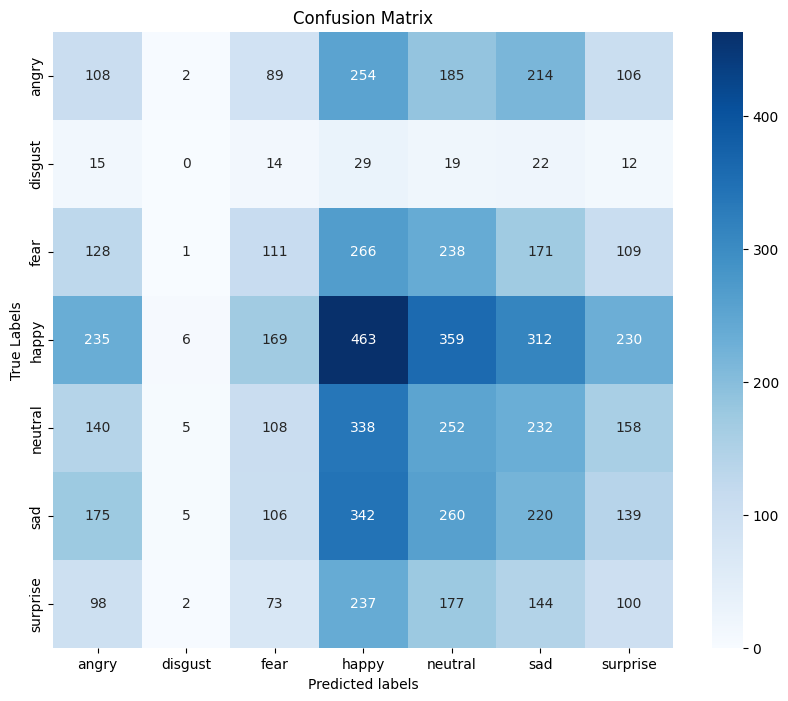

In [16]:
#get the true labels
true_labels=test_generator.classes
predicted_labels=model.predict(test_generator).argmax(axis=-1)

#confusion matrix
cm=confusion_matrix(true_labels,predicted_labels)

plt.figure(figsize=(10,8))
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',xticklabels=test_generator.class_indices.keys(),yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted labels')
plt.ylabel('True Labels')
plt.title("Confusion Matrix")

plt.show()